In [383]:
import os
import numpy as np
import numpy.ma as ma
from astropy.io import ascii
from astropy.table import Table,Column,JSViewer
from astropy import units as u
from astropy.visualization import quantity_support
from astropy.constants import L_sun, M_sun, R_sun,sigma_sb
from math import pi
quantity_support()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
#import pandas as pd


In [332]:
dir = 'fits_ugriz'
input_files = []
for file in os.listdir(dir):
    if file.endswith(".txt"):
        fname = os.path.join(dir, file)
        input_files.append(fname)
# get the headers
colnames = []
f = open(input_files[0],'r')
z= f.readline().split()
colnames.extend(z)
z= f.readline().split()
colnames.extend(z)
# get junk line
f.readline()
colvalues=[]
colvalues.extend(f.readline().split())
colvalues.extend(f.readline().split())
f.close()
colunits = ['' for x in colvalues]
colunits[6] = 'mag'
# another way
x = colvalues[8]*u.solRad
colvalues[8] = x.decompose().scale
#colvalues[8] *= R_sun
#colvalues[8] = colvalues[8].value
print(type(colvalues[8]))
colunits[8] = 'm'
colunits[9]  = 'K'
colunits[11] = 'degree'
coldtypes=[np.dtype(np.object),np.dtype(np.int32),np.dtype(np.int32),np.dtype(np.int32),np.dtype(np.object),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float),np.dtype(np.float)]
coldesc = ['name', 'number of fit points', 'number of fits', 'fit number','best fit model', 'goodness of fit', 'extinction', 'scale factor', 'stellar radius', 'stellar temperature', 'scattering', 'viewing angle']
#for i in range(len(colnames)):
#  print('%s %s %s %s %s'% (colnames[i],colvalues[i],colunits[i],coldtypes[i],coldesc[i]))



<class 'float'>


In [333]:
t = Table(names=colnames,dtype=coldtypes)
#t.add_row(colvalues)
#for i in range(len(colnames)):
#   c = Column([colvalues[i]],unit=colunits[i],description=coldesc[i])
#   t[colnames[i]] = c
#   print(colnames[i])
#print(t['chi2'])
for i in range(len(colnames)):
    t[colnames[i]].unit = colunits[i]
for i in range(0,len(input_files)):
    f = open(input_files[i],'r')
    f.readline()
    f.readline()
    f.readline()
    colvalues=[]
    colvalues.extend(f.readline().split())
    colvalues.extend(f.readline().split())
    x = colvalues[8]*u.solRad
    colvalues[8] = x.decompose().scale
    #colvalues[8] = float(colvalues[8])*R_sun
    #colvalues[8] = colvalues[8].value
    t.add_row(colvalues)
    f.close()
t.add_index('source_name')
#t.loc['BD+2_3375']['star.radius']

    

In [334]:
#print(sigma_sb)
t['star.luminosity'] = 4.0*pi*sigma_sb*(t['star.radius']**2)*(t['star.temperature']**4)
t['star.Lsun'] = t['star.luminosity']/L_sun
t['star.luminosity'].unit = 'W'
t['star.luminosity'].format='4.3E'
t['star.radius'].format='4.3E'
t['star.Lsun'].unit='Lsun'
t['star.Lsun'].format='5.3f'
t['star.Rsun'] = t['star.radius']/R_sun # yes I know...
t['star.Lsun'].unit='Rsun'
t['star.Lsun'].format='5.3f'

#print(L_sun)
#print(1*u.solRad.decompose().scale)
#print((4*pi*sigma_sb*(R_sun**2)*(5830*u.K)**4)/L_sun)

t['star.SpType'] = Column(name='star.SpType',length=len(t),dtype=np.object)
standards = Table.read("sdss_standards.votab")
sptype = []
standards.add_index('StarName')
for j in t['source_name']:
    spacename = j.replace('_',' ')
    t.loc[j]['star.SpType']= standards.loc[spacename]['SpType']
#    print(standards.loc[spacename]['SpType'],standards.loc[spacename]['MK_Spectral_type'])
t.show_in_notebook(display_length=2)

idx,source_name,n_data,n_fits,fit_id,model_name,chi2,av,scale,star.radius,star.temperature,scattering,inclination,star.luminosity,star.Lsun,star.Rsun,star.SpType
,,,,,,,mag,,m,K,,deg,W,solRad,,
0,BD+17_4708,5,1,1,GbuVahpU_01,125903.942,1.142,-0.911,7.256E+08,8288.0,1.0,45.0,1.770E+27,4.624,1.043,sdF8
1,BD+18_3407,5,1,1,FOjcyApo_01,141235.775,0.0,-1.22,4.462E+08,5204.0,1.0,45.0,1.041E+26,0.272,0.6414,G5
2,BD+2_3375,5,1,1,tCyI6r2d_01,69318.981,1.165,-0.995,4.847E+08,8442.0,1.0,45.0,8.502E+26,2.221,0.6967,sdGO
3,BD+21_0607,5,1,1,0yTkY1Ak_01,79522.908,0.837,-1.055,5.226E+08,8264.0,1.0,45.0,9.077E+26,2.371,0.7512,sdF5
4,BD+25_1981,5,1,1,gtUluvfP_01,17538.892,0.492,-0.86,6.778E+08,8126.0,1.0,45.0,1.427E+27,3.729,0.9743,sdF2
5,BD+25_4655,5,2,1,FtUzsGUA_01,20795.692,0.0,-0.932,1.450E+08,20920.0,1.0,45.0,2.869E+27,7.494,0.2084,sdO0
6,BD+26_2606,5,1,1,GbuVahpU_01,111921.542,1.036,-0.842,7.256E+08,8288.0,1.0,45.0,1.770E+27,4.624,1.043,sdF4
7,BD+28_4211,5,2,1,nFCotFuO_01,12357.419,0.0,-0.95,8.988E+07,21780.0,1.0,45.0,1.295E+27,3.384,0.1292,Op
8,BD+29_2091,5,4,1,lzrhtth5_01,1703.615,0.963,-1.056,3.629E+08,7997.0,1.0,45.0,3.838E+26,1.002,0.5216,sdG5


In [350]:
def getcolor(i):
    if i == "N/A": return 'black'
    if i.startswith("O") or i.startswith("sdO"): return 'gray'
    if i.startswith("B") or i.startswith("sdB"): return 'blue'
    if i.startswith("A") or i.startswith("sdA"): return 'cyan'
    if i.startswith("F") or i.startswith("sdF"): return 'gold'
    if i.startswith("G") or i.startswith("sdG"): return 'green'
    if i.startswith("K") or i.startswith("sdK"): return 'orange'
    if i.startswith("M") or i.startswith("sdM"): return 'red'
    if i.startswith("DA"): return'purple'
    return 'black'


def getlumclass(i):
    if(i.endswith("III")): return "^"
    if(i.endswith("VII") or i.startswith("DA")): return "*"
    if(i.endswith("VI")) or i.startswith("sd"): return "s"
    if(i.endswith("II")): return "v"
    if(i.endswith("IV")): return "+"
    if(i.endswith("V")): return "o"
    if(i.endswith("I")): return "P"
    return "o"
classes = []
colors = []
for j in t['star.SpType']:
    colors.append(getcolor(j))
    classes.append(getlumclass(j))
    
lu = dict()
lu['P'] = 'I'
lu['v'] = 'II'
lu['^'] = 'III'
lu['+'] = 'VI'
lu['o'] = 'V or other'
lu['s'] = 'sd'
lu['*'] = 'WD'


#classes
#g = dict.fromkeys((t['star.SpType']))
#len(g)
#for i in g:
#    g[i] = 'black'
#    if i == "N/A": g[i] = 'black'
#    if i.startswith("O") or i.startswith("sdO"): g[i] = 'gray'
#    if i.startswith("B") or i.startswith("sdB"): g[i] = 'blue'
#    if i.startswith("A") or i.startswith("sdA"): g[i] = 'cyan'
#    if i.startswith("F") or i.startswith("sdF"): g[i] = 'yellow'
#    if i.startswith("G") or i.startswith("sdG"): g[i] = 'green'
#    if i.startswith("K") or i.startswith("sdK"): g[i] = 'orange'
#    if i.startswith("M") or i.startswith("sdM"): g[i] = 'red'
#    if i.startswith("DA"): g[i] = 'purple'
#len(list(g.values()))

In [336]:
t.write('ugriz_parameters.tab',format='votable',overwrite=True)

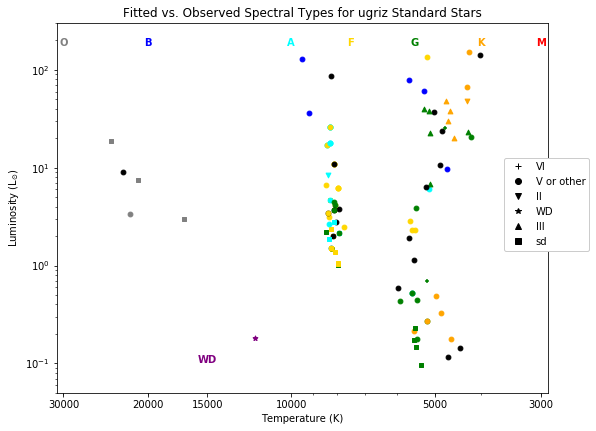

In [389]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8.8,6.8]
import matplotlib.ticker
for x,y,c,m in zip(t['star.temperature'],t['star.Lsun'],colors,classes):
#plt.scatter((t['star.temperature']),(t['star.Lsun']),c=colors,s=10,marker=classes)
    plt.scatter(x,y,c=c,s=23,marker=m)
plt.xlim(2900,31000)
plt.ylim(0.05,300)
plt.xlabel("Temperature (K)")
plt.ylabel("Luminosity (L$_{\odot}$)")
plt.gca().invert_xaxis()
plt.text(30000,175,"O",horizontalalignment='center',color=getcolor("O"),weight='bold')
plt.text(20000,175,"B",horizontalalignment='center',color=getcolor("B"),weight='bold')
plt.text(10000,175,"A",horizontalalignment='center',color=getcolor("A"),weight='bold')
plt.text(7500,175,"F",horizontalalignment='center',color=getcolor("F"),weight='bold')#,backgroundcolor='gray')
plt.text(5500,175,"G",horizontalalignment='center',color=getcolor("G"),weight='bold')
plt.text(4000,175,"K",horizontalalignment='center',color=getcolor("K"),weight='bold')
plt.text(3000,175,"M",horizontalalignment='center',color=getcolor("M"),weight='bold')
plt.text(15000,0.1,"WD",horizontalalignment='center',color=getcolor("DA"),weight='bold')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.gca().set_xticks([3000,5000,10000,15000,20000,30000])
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())
u = list(set(classes))
plt.title('Fitted vs. Observed Spectral Types for ugriz Standard Stars')

patches = [plt.plot([],[],marker=z,ls="",color='black',label=lu[z])[0] for z in u]
plt.legend(handles=patches,loc='best',numpoints=1,ncol=1, bbox_to_anchor=(.9,0.65),framealpha=1)
#print(len(u),len(lu))
plt.savefig("HRdiagram.pdf")
